# ScoreSight - Top Goal Scorer Prediction
Author: Rishi Khandekar

Internship: Infosys

Goal: Predict total goals scored by a player in a season (regression)

Dataset loaded successfully.

--- Data Overview ---
Shape: (324, 20)
    Season  Rank           Player              Club  Goals  \
0  2023-24     1   Erling Haaland   Manchester City     27   
1  2023-24     2      Cole Palmer           Chelsea     22   
2  2023-24     3   Alexander Isak  Newcastle United     21   
3  2023-24     4    Ollie Watkins       Aston Villa     19   
4  2023-24     4  Dominic Solanke   AFC Bournemouth     19   

               Position  Age  Appearances  Minutes_Played  Goals_prev_season  \
0               Forward   23           31            2682                 36   
1  Attacking Midfielder   22           33            2674                  3   
2               Forward   24           30            2403                 10   
3               Forward   28           37            3302                 15   
4               Forward   26           38            3355                  6   

   Assists  Penalty_Goals  Non-Penalty_Goals  Goals_per_90  \
0        6     

C:\Users\rishi\AppData\Local\Temp\ipykernel_12268\2362057282.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette="mako")


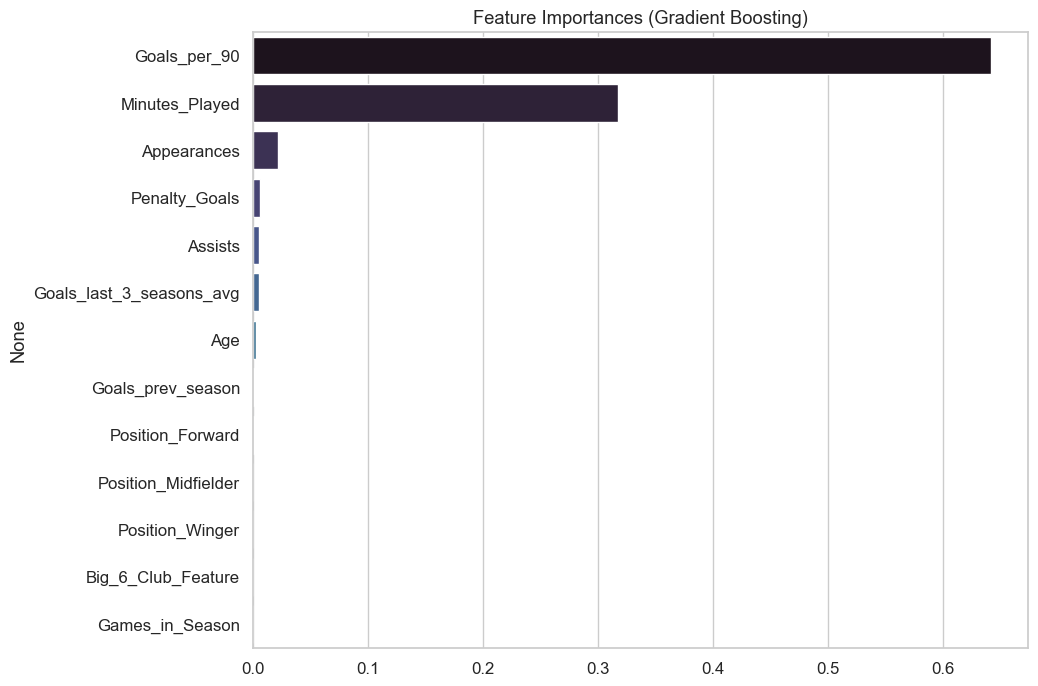

In [1]:
# ==========================================================
# ⚽ Premier League Top Goal Scorer Prediction Model (Gradient Boosting)
# Goal: Predict the continuous number of goals a player will score in a season.
# ==========================================================

# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer # Used to handle missing values robustly

# Set a consistent visual style for plots
sns.set(style="whitegrid", font_scale=1.1, palette="viridis")

# 2. Load the Dataset
# Assuming the file 'topgoals.csv' is in the same directory
try:
    df = pd.read_csv("topgoals.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'topgoals.csv' not found. Please ensure the file is in the correct location.")
    exit()

# 3. Data Exploration (Similar to your friend's initial steps)
print("\n--- Data Overview ---")
print(f"Shape: {df.shape}")
print(df.head())
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# 4. Feature Selection (Matching friend's likely feature and drop list)
TARGET = 'Goals'

# Features to drop (Similar to the selection in the original notebook and inference from the new one)
DROP_COLS = [
    'Rank', 'Player', 'Club', 'Season', 'Non-Penalty_Goals',
    'Club_League_Rank', 'Club_Total_Goals', 'League_Goals_per_Match',
    # Keeping 'Penalty_Goals' as it might be relevant, but 'Goals_per_90' is calculated from data we have.
]

df = df.drop(columns=[col for col in DROP_COLS if col in df.columns])
print("\n--- Features Remaining for Model ---")
print(df.columns.tolist())

# 5. Handling Missing Values and Categorical Encoding
# Use SimpleImputer for a robust way to handle N/A in the original data

# Impute numeric columns with median
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
imputer_numeric = SimpleImputer(missing_values=np.nan, strategy='median')
df[numeric_cols] = imputer_numeric.fit_transform(df[numeric_cols])

# Impute categorical (object) columns with the most frequent value
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df[col] = imputer_cat.fit_transform(df[[col]])[:, 0]

print("\nMissing values after imputation:")
print(df.isnull().sum().sum()) # Should be 0

# One-Hot Encoding for 'Position' (The only remaining object column)
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(f"\nShape after encoding: {df_encoded.shape}")

# 6. Define X and y
X = df_encoded.drop(columns=[TARGET])
y = df_encoded[TARGET]

# 7. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nTrain/Test Split: Train {X_train.shape}, Test {X_test.shape}")

# 8. Define Evaluation Function
def regression_metrics(y_true, y_pred):
    """Calculates MAE, RMSE, and R2 for regression evaluation."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

# 9. Train the Gradient Boosting Regressor (Matching friend's model choice)
print("\n--- Training Gradient Boosting Regressor ---")
gbr = GradientBoostingRegressor(
    n_estimators=100,      # Number of boosting stages
    learning_rate=0.1,     # Shrinkage factor
    max_depth=3,           # Max depth of individual regression estimators
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
gbr_metrics = regression_metrics(y_test, y_pred_gbr)

print("\n📌 Gradient Boosting Regressor Performance:")
for k, v in gbr_metrics.items():
    print(f"{k}: {v:.4f}")

# 10. Visualize Feature Importance
if hasattr(gbr, "feature_importances_"):
    fi = pd.Series(gbr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 8))
    # Only show top features to keep the plot readable
    sns.barplot(x=fi.values, y=fi.index, palette="mako") 
    plt.title("Feature Importances (Gradient Boosting)")
    plt.show()
